In [ ]:
!unzip /content/drive/MyDrive/Lung_Adenocarcinoma_Dataset.zip

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip /content/drive/MyDrive/file1.zip

In [ ]:
!apt-get install openslide-tools
!pip install openslide-python
!pip install opencv-python

In [ ]:
!pip install tensorflow==2.3.1

In [ ]:
import pandas as pd
train_df=pd.read_csv("/content/drive/MyDrive/MetaData_Release_1.0.csv")

In [ ]:
!mkdir wsi_train
!mkdir wsi_train/solid
!mkdir wsi_train/lepidic
!mkdir wsi_train/micropapillary
!mkdir wsi_train/papillary
!mkdir wsi_train/acinar

In [ ]:
for i in range(len(train_df["Class"])):
  src_path="/content/" + train_df["File Name"][i]

  if train_df["Class"][i]=="solid":
    des_path="/content/wsi_train/solid/"
    !mv $src_path $des_path

  elif train_df["Class"][i]=="lepidic":
    des_path="/content/wsi_train/lepidic/"
    !mv $src_path $des_path
  elif train_df["Class"][i]=="micropapillary":  
    des_path="/content/wsi_train/micropapillary/"
    !mv $src_path $des_path
  elif train_df["Class"][i]=="papillary":
    des_path="/content/wsi_train/papillary/"
    !mv $src_path $des_path
  elif train_df["Class"][i]=="acinar":
    des_path="/content/wsi_train/acinar/"
    !mv $src_path $des_path

In [ ]:
import os
solid_training_path_list=os.listdir("/content/wsi_train/solid")
lepidic_training_path_list=os.listdir("/content/wsi_train/lepidic")
micropapillary_training_path_list=os.listdir("/content/wsi_train/micropapillary")
papillary_training_path_list=os.listdir("/content/wsi_train/papillary")
acinar_training_path_list=os.listdir("/content/wsi_train/acinar")

In [ ]:
!mkdir train_folder
!mkdir train_folder/train

In [ ]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

import os
import numpy as np
%matplotlib inline

from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np


## Must be openslide version 3.4.1
from openslide import open_slide, __library_version__ as openslide_version
print(openslide_version)
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0,1"

3.4.1


In [ ]:
import tensorflow as tf


import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
from skimage.color import rgb2gray
import cv2
import os
import random
import pathlib
import openslide
import PIL
from PIL import Image
from openslide.lowlevel import *
from openslide.lowlevel import _convert


def _load_image_lessthan_2_29(buf, size):
    '''buf must be a mutable buffer.'''
    _convert.argb2rgba(buf)
    return PIL.Image.frombuffer('RGBA', size, buf, 'raw', 'RGBA', 0, 1)


def _load_image_morethan_2_29(buf, size):
    '''buf must be a buffer.'''

    # Load entire buffer at once if possible
    MAX_PIXELS_PER_LOAD = (1 << 29) - 1
    # Otherwise, use chunks smaller than the maximum to reduce memory
    # requirements
    PIXELS_PER_LOAD = 1 << 26

    def do_load(buf, size):
        '''buf can be a string, but should be a ctypes buffer to avoid an
        extra copy in the caller.'''
        # First reorder the bytes in a pixel from native-endian aRGB to
        # big-endian RGBa to work around limitations in RGBa loader
        rawmode = (sys.byteorder == 'little') and 'BGRA' or 'ARGB'
        buf = PIL.Image.frombuffer('RGBA', size, buf, 'raw', rawmode, 0, 1)
        # Image.tobytes() is named tostring() in Pillow 1.x and PIL
        buf = (getattr(buf, 'tobytes', None) or buf.tostring)()
        # Now load the image as RGBA, undoing premultiplication
        return PIL.Image.frombuffer('RGBA', size, buf, 'raw', 'RGBa', 0, 1)

    # Fast path for small buffers
    w, h = size
    if w * h <= MAX_PIXELS_PER_LOAD:
        return do_load(buf, size)

    # Load in chunks to avoid OverflowError in PIL.Image.frombuffer()
    # https://github.com/python-pillow/Pillow/issues/1475
    if w > PIXELS_PER_LOAD:
        # We could support this, but it seems like overkill
        raise ValueError('Width %d is too large (maximum %d)' %
                         (w, PIXELS_PER_LOAD))
    rows_per_load = PIXELS_PER_LOAD // w
    img = PIL.Image.new('RGBA', (w, h))
    for y in range(0, h, rows_per_load):
        rows = min(h - y, rows_per_load)
        if sys.version[0] == '2':
            chunk = buffer(buf, 4 * y * w, 4 * rows * w)
        else:
            # PIL.Image.frombuffer() won't take a memoryview or
            # bytearray, so we can't avoid copying
            chunk = memoryview(buf)[y * w:(y + rows) * w].tobytes()
        img.paste(do_load(chunk, (w, rows)), (0, y))
    return img


def read_slide(slide, x, y, level, width, height, as_float=False):

    # Reading the slides and converting them into a RGB numpy array
    openslide.lowlevel._load_image = _load_image_morethan_2_29
    im = slide.read_region((x, y), level, (width, height))
    im = im.convert('RGB')  # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im


def find_tissue_pixels(image, intensity=0.8):

    # Finding the pixels having value less than or equal to the intensity value
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])


def apply_mask(im, mask, color=1):

    # Applies the mask to the slides image
    masked = np.zeros((im.shape[0], im.shape[1]))
    for x, y in mask:
        masked[x][y] = color
    return masked


# This function makes the directories required during testing
def initialize_directories_test(slide_path, level):

    BASE_DIR = os.getcwd()

    img_num = slide_path[-13:-4]

    DATA = 'train_folder/'
    TRAIN="train/"
    IMG_NUM_FOLDER = img_num + '/'
    LEVEL_FOLDER = 'level_'+str(level)+'/'
    TISSUE_FOLDER = 'tissue_only/'
    ALL_FOLDER = 'all/'

    DATA_DIR = os.path.join(BASE_DIR, DATA)
    TRAIN_DIR = os.path.join(BASE_DIR, DATA,TRAIN)
    IMG_NUM_DIR = os.path.join(BASE_DIR, DATA,TRAIN, IMG_NUM_FOLDER)
    LEVEL_NUM_DIR = os.path.join(BASE_DIR, DATA,TRAIN, IMG_NUM_FOLDER, LEVEL_FOLDER)
    TISSUE_DIR = os.path.join(BASE_DIR, DATA,TRAIN, IMG_NUM_FOLDER, LEVEL_FOLDER, TISSUE_FOLDER)
    ALL_DIR = os.path.join(BASE_DIR, DATA,TRAIN, IMG_NUM_FOLDER, LEVEL_FOLDER, ALL_FOLDER)

    if not os.path.exists(DATA_DIR):
        os.mkdir(DATA_DIR)
    if not os.path.exists(TRAIN_DIR):
        os.mkdir(TRAIN_DIR)    
    if not os.path.exists(IMG_NUM_DIR):
        os.mkdir(IMG_NUM_DIR)
    if not os.path.exists(LEVEL_NUM_DIR):
        os.mkdir(LEVEL_NUM_DIR)
    if not os.path.exists(TISSUE_DIR):
        os.mkdir(TISSUE_DIR)
    if not os.path.exists(ALL_DIR):
        os.mkdir(ALL_DIR)

    return DATA + TRAIN + IMG_NUM_FOLDER + LEVEL_FOLDER + TISSUE_FOLDER, DATA + TRAIN + IMG_NUM_FOLDER + LEVEL_FOLDER + ALL_FOLDER


# This function is used to create the directories during training
def initialize_directories(slide_path, level):
    BASE_DIR = os.getcwd()

    img_num = slide_path.split('_')[1].strip(".tiff")

    DATA = 'data/'
    IMG_NUM_FOLDER = img_num + '/'
    LEVEL_FOLDER = 'level_'+str(level)+'/'
    TUMOR_FOLDER = 'tumor/'
    NO_TUMOR_FOLDER = 'no_tumor/'

    DATA_DIR = os.path.join(BASE_DIR, DATA)
    IMG_NUM_DIR = os.path.join(BASE_DIR, DATA, IMG_NUM_FOLDER)
    LEVEL_NUM_DIR = os.path.join(BASE_DIR, DATA, IMG_NUM_FOLDER, LEVEL_FOLDER)
    TUMOR_DIR = os.path.join(BASE_DIR, DATA, IMG_NUM_FOLDER, LEVEL_FOLDER, TUMOR_FOLDER)
    NO_TUMOR_DIR = os.path.join(BASE_DIR, DATA, IMG_NUM_FOLDER, LEVEL_FOLDER, NO_TUMOR_FOLDER)

    if not os.path.exists(DATA_DIR):
        os.mkdir(DATA_DIR)
    if not os.path.exists(IMG_NUM_DIR):
        os.mkdir(IMG_NUM_DIR)
    if not os.path.exists(LEVEL_NUM_DIR):
        os.mkdir(LEVEL_NUM_DIR)
    if not os.path.exists(TUMOR_DIR):
        os.mkdir(TUMOR_DIR)
    if not os.path.exists(NO_TUMOR_DIR):
        os.mkdir(NO_TUMOR_DIR)

    return DATA + IMG_NUM_FOLDER + LEVEL_FOLDER + TUMOR_FOLDER, DATA + IMG_NUM_FOLDER + LEVEL_FOLDER + NO_TUMOR_FOLDER


# Save the image as tissue or not
def split_image_test(im, tissue_mask, num_pixels, level_num, slide_path):
    x, y = im.shape[0], im.shape[1]
    x_count, y_count = int(np.ceil(x / num_pixels)), int(np.ceil(y / num_pixels))

    tissue_folder, all_folder = initialize_directories_test(slide_path, level_num)

    try:
        for i in range(x_count):
            for j in range(y_count):
                im_slice = np.zeros((num_pixels, num_pixels, 3))
                im_tissue_slice = np.zeros((num_pixels, num_pixels, 3))
                tissue_mask_slice = np.zeros((num_pixels, num_pixels))

                string_name = 'img_' + str(i * y_count + j)

                # Logic to handle the edges of the images
                if i == x_count - 1:
                    ub_x = x
                    assign_x = x - (x_count - 1) * num_pixels
                else:
                    ub_x = (i + 1) * num_pixels
                    assign_x = num_pixels

                if j == y_count - 1:
                    ub_y = y
                    assign_y = y - (y_count - 1) * num_pixels
                else:
                    ub_y = (j + 1) * num_pixels
                    assign_y = num_pixels

                tissue_mask_slice[0:assign_x, 0:assign_y] = tissue_mask[(i * num_pixels):ub_x, (j * num_pixels):ub_y]

                try:
                    if np.mean(tissue_mask_slice) > 0.7:
                        im_tissue_slice[0:assign_x, 0:assign_y, :] = im[(i * num_pixels):ub_x, (j * num_pixels):ub_y, :]
                        im_file_name_tissue = tissue_folder + string_name + ".jpg"
                        cv2.imwrite(im_file_name_tissue, im_tissue_slice)

                    im_slice[0:assign_x, 0:assign_y, :] = im[(i * num_pixels):ub_x, (j * num_pixels):ub_y, :]
                    im_file_name_all = all_folder + string_name + ".jpg"
                    cv2.imwrite(im_file_name_all, im_slice)

                except Exception as oerr:
                    print('Error with saving:', oerr)

    except Exception as oerr:
        print('Error with slicing:', oerr)



import tensorflow as tf


import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
from skimage.color import rgb2gray
import cv2
import os
import random
import pathlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import pandas as pd
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

# Load and preprocess image.
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

#Preprocess image
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 128])
    image /= 255.0  # normalize to [0,1] range

    return image



def load_image(slide_path):

    # Loading the slide image and the tumor mask image
    slide = open_slide(slide_path)
  
    
    # Checking if the dimensions of the mask image and the slide image match or not
  
    print(slide.level_dimensions)
    print("---",slide.level_downsamples[2],slide.level_dimensions[2][0])
    # Verify downsampling works as expected
    width, height = slide.level_dimensions[2]
    print(width,height)
    #assert width * slide.level_downsamples[2] == slide.level_dimensions[2][0]
    #assert height * slide.level_downsamples[2] == slide.level_dimensions[0][1]

    return slide

In [ ]:
def test_part_1(testing_image_path, num_pixels=64, num_level=2):

    slide_path_test = testing_image_path
  
    print(slide_path_test)

    # Retrieve slide parameters before overwriting
    slide = load_image(slide_path_test)
    width, height = slide.level_dimensions[num_level][0], slide.level_dimensions[num_level][1]

    # Read training image at slide level 3
    slide = read_slide(slide,
                       x=0,
                       y=0,
                       level=num_level,
                       width=width,
                       height=height)

    

    # Retrieve new array dimensions
    image_depth, image_width = int(np.ceil(slide.shape[0] / num_pixels)), int(np.ceil(slide.shape[1] / num_pixels))

    

    # Determine the portions of the image that are tissue
    tissue_pixels = list(find_tissue_pixels(slide))

    # Turn the tissue pixels into a mask
    tissue_regions = apply_mask(slide, tissue_pixels)

    split_image_test(slide, tissue_regions, num_pixels, num_level, slide_path_test)
    return image_depth, image_width, tissue_regions, slide

In [ ]:
solid_training_path_list

[]

In [ ]:
file_path="/content/wsi_train/solid/" + solid_training_path_list[0]
image_depth, image_width, tissue_regions, slide_image_test = test_part_1(file_path,
                                                                           num_pixels=128,
                                                                           num_level = 3)

/content/wsi_train/solid/DHMC_0132.tif
((55776, 42145), (27888, 21072), (13944, 10536), (6972, 5268), (3486, 2634), (1743, 1317), (871, 658), (435, 329), (217, 164))
--- 4.000047456340167 13944
13944 10536


In [ ]:
!rm -r $file_path

In [ ]:
for i in range(len(solid_training_path_list)):
  check="/content/wsi_train/solid/"
  file_path="/content/wsi_train/solid/" + solid_training_path_list[i]
  if solid_training_path_list[i] in os.listdir(check):
    image_depth, image_width, tissue_regions, slide_image_test = test_part_1(file_path,
                                                                           num_pixels=128,
                                                                           num_level = 2)
    !rm -r $file_path

In [ ]:
lepidic_training_path_list

[]

In [ ]:
file_path="/content/wsi_train/lepidic/" + lepidic_training_path_list[0]

image_depth, image_width, tissue_regions, slide_image_test = test_part_1(file_path,
                                                                           num_pixels=128,
                                                                           num_level = 4)
!rm -r $file_path

/content/wsi_train/lepidic/DHMC_0090.tif
((113544, 83989), (56772, 41994), (28386, 20997), (14193, 10498), (7096, 5249), (3548, 2624), (1774, 1312), (887, 656), (443, 328), (221, 164))
--- 4.000023812925656 28386
28386 20997


In [ ]:
for i in range(len(lepidic_training_path_list)):
  check="/content/wsi_train/lepidic/"
  file_path="/content/wsi_train/lepidic/" + lepidic_training_path_list[i]
  if lepidic_training_path_list[i] in os.listdir(check):
    image_depth, image_width, tissue_regions, slide_image_test = test_part_1(file_path,
                                                                           num_pixels=128,
                                                                           num_level = 2)
    !rm -r $file_path

In [ ]:
micropapillary_training_path_list

[]

In [ ]:
for i in range(len(micropapillary_training_path_list)):
  check="/content/wsi_train/micropapillary/"
  file_path="/content/wsi_train/micropapillary/" + micropapillary_training_path_list[i]
  if micropapillary_training_path_list[i] in os.listdir(check):
    image_depth, image_width, tissue_regions, slide_image_test = test_part_1(file_path,
                                                                           num_pixels=128,
                                                                           num_level = 2)
    !rm -r $file_path

In [ ]:
papillary_training_path_list

[]

In [ ]:
for i in range(len(papillary_training_path_list)):
  check="/content/wsi_train/papillary/"
  file_path="/content/wsi_train/papillary/" + papillary_training_path_list[i]
  if papillary_training_path_list[i] in os.listdir(check):
    image_depth, image_width, tissue_regions, slide_image_test = test_part_1(file_path,
                                                                           num_pixels=128,
                                                                           num_level = 2)
    !rm -r $file_path

/content/wsi_train/papillary/DHMC_0098.tif
((47808, 25935), (23904, 12967), (11952, 6483), (5976, 3241), (2988, 1620), (1494, 810), (747, 405), (373, 202), (186, 101))
--- 4.00023137436372 11952
11952 6483


In [ ]:
acinar_training_path_list

['DHMC_0091.tif',
 'DHMC_0087.tif',
 'DHMC_0082.tif',
 'DHMC_0093.tif',
 'DHMC_0099.tif',
 'DHMC_0100.tif',
 'DHMC_0118.tif',
 'DHMC_0085.tif',
 'DHMC_0080.tif',
 'DHMC_0113.tif',
 'DHMC_0095.tif',
 'DHMC_0081.tif',
 'DHMC_0092.tif']

In [ ]:
file_path="/content/wsi_train/acinar/" + acinar_training_path_list[0]
image_depth, image_width, tissue_regions, slide_image_test = test_part_1(file_path,
                                                                           num_pixels=128,
                                                                           num_level = 3)

/content/wsi_train/acinar/DHMC_0066.tif
((83664, 71769), (41832, 35884), (20916, 17942), (10458, 8971), (5229, 4485), (2614, 2242), (1307, 1121), (653, 560), (326, 280), (163, 140))
--- 4.000027867573292 20916
20916 17942


In [ ]:
a="/content/wsi_train/acinar/"+ acinar_training_path_list[0]
!rm -r $a

In [ ]:
acinar_training_path_list

['DHMC_0099.tif',
 'DHMC_0100.tif',
 'DHMC_0118.tif',
 'DHMC_0085.tif',
 'DHMC_0080.tif',
 'DHMC_0113.tif',
 'DHMC_0095.tif',
 'DHMC_0081.tif',
 'DHMC_0092.tif']

In [ ]:
file_path="/content/wsi_train/acinar/" + acinar_training_path_list[8]

image_depth, image_width, tissue_regions, slide_image_test = test_part_1(file_path,
                                                                           num_pixels=128,
                                                                           num_level = 3)
!rm -r $file_path

/content/wsi_train/acinar/DHMC_0092.tif
((93624, 81260), (46812, 40630), (23406, 20315), (11703, 10157), (5851, 5078), (2925, 2539), (1462, 1269), (731, 634), (365, 317), (182, 158))
--- 4.0 23406
23406 20315


In [ ]:
for i in range(len(acinar_training_path_list)):
  check="/content/wsi_train/acinar/"
  file_path="/content/wsi_train/acinar/" + acinar_training_path_list[i]
  if acinar_training_path_list[i] in os.listdir(check):
    image_depth, image_width, tissue_regions, slide_image_test = test_part_1(file_path,
                                                                           num_pixels=128,
                                                                           num_level = 2)
    !rm -r $file_path

/content/wsi_train/acinar/DHMC_0095.tif
((53783, 27841), (26891, 13920), (13445, 6960), (6722, 3480), (3361, 1740), (1680, 870), (840, 435), (420, 217), (210, 108))
--- 4.000183404718244 13445
13445 6960
/content/wsi_train/acinar/DHMC_0081.tif
((43824, 29562), (21912, 14781), (10956, 7390), (5478, 3695), (2739, 1847), (1369, 923), (684, 461), (342, 230), (171, 115))
--- 4.000135317997294 10956
10956 7390
/content/wsi_train/acinar/DHMC_0092.tif
((93624, 81260), (46812, 40630), (23406, 20315), (11703, 10157), (5851, 5078), (2925, 2539), (1462, 1269), (731, 634), (365, 317), (182, 158))
--- 4.0 23406
23406 20315


KeyboardInterrupt: ignored

In [ ]:
!ls train_folder/train/DHMC_0040/level_2/tissue_only  

img_1009.jpg  img_2272.jpg  img_2776.jpg  img_3299.jpg	img_3802.jpg
img_1070.jpg  img_2273.jpg  img_2777.jpg  img_3324.jpg	img_3803.jpg
img_1305.jpg  img_2277.jpg  img_2778.jpg  img_3393.jpg	img_3804.jpg
img_1405.jpg  img_2286.jpg  img_2796.jpg  img_3398.jpg	img_3806.jpg
img_1559.jpg  img_2287.jpg  img_2884.jpg  img_3401.jpg	img_3817.jpg
img_1563.jpg  img_2295.jpg  img_2885.jpg  img_3496.jpg	img_3818.jpg
img_1662.jpg  img_2316.jpg  img_2886.jpg  img_350.jpg	img_3820.jpg
img_1663.jpg  img_2371.jpg  img_2887.jpg  img_351.jpg	img_3821.jpg
img_1664.jpg  img_2372.jpg  img_2888.jpg  img_3521.jpg	img_3822.jpg
img_1774.jpg  img_2373.jpg  img_2895.jpg  img_356.jpg	img_3823.jpg
img_1775.jpg  img_2374.jpg  img_2974.jpg  img_357.jpg	img_3908.jpg
img_1876.jpg  img_2375.jpg  img_2983.jpg  img_358.jpg	img_3920.jpg
img_1892.jpg  img_2379.jpg  img_2987.jpg  img_3598.jpg	img_4013.jpg
img_2053.jpg  img_2388.jpg  img_2988.jpg  img_359.jpg	img_4018.jpg
img_2054.jpg  img_2389.jpg  img_2989.jpg  img_360.jpg	

In [ ]:
!mkdir Dataset
!mkdir Dataset/train_filter
!mkdir Dataset/train_filter/level_2
!mkdir Dataset/train_filter/level_2/acinar
!mkdir Dataset/train_filter/level_2/lepidic
!mkdir Dataset/train_filter/level_2/micropapillary
!mkdir Dataset/train_filter/level_2/papillary
!mkdir Dataset/train_filter/level_2/solid

In [ ]:
import os
path = os.listdir("/content/train_folder/train")

In [ ]:
path

In [ ]:
for i in range(len(train_df)):
  for k in range(len(path)):
    equality=path[k]+".tif"
    print(train_df["File Name"][i])
    src_path="/content/train_folder/train/" + path[k] +"/level_2/" + "tissue_only"
    delete="/content/train_folder/train/"+ path[k]

    if train_df["File Name"][i] == equality and train_df["Class"][i] == "acinar":
      des_path="/content/Dataset/train_filter/level_2/acinar"
      !cp -r $src_path $des_path
      !rm -r $delete

    elif train_df["File Name"][i] == equality and train_df["Class"][i] == "lepidic":
      des_path="/content/Dataset/train_filter/level_2/lepidic"
      !cp -r $src_path $des_path
      !rm -r $delete

    elif train_df["File Name"][i] == equality and train_df["Class"][i] == "micropapillary":
      des_path="/content/Dataset/train_filter/level_2/micropapillary"
      !cp -r $src_path $des_path
      !rm -r $delete

    elif train_df["File Name"][i] == equality and train_df["Class"][i] == "papillary":
      des_path="/content/Dataset/train_filter/level_2/papillary"
      !cp -r $src_path $des_path
      !rm -r $delete

    elif train_df["File Name"][i] == equality and train_df["Class"][i] == "solid":
      des_path="/content/Dataset/train_filter/level_2/solid"
      !cp -r $src_path $des_path
      !rm -r $delete 

In [ ]:
import os
len(os.listdir("/content/Dataset/train_filter/level_2/lepidic/tissue_only"))

4653

In [ ]:
import os
len(os.listdir("/content/Dataset/train_filter/level_2/lepidic/tissue_only"))

2180

In [ ]:
import os
len(os.listdir("/content/Dataset/train_filter/level_2/acinar/tissue_only"))

7049

In [ ]:
import os
len(os.listdir("/content/Dataset/train_filter/level_2/acinar/tissue_only"))

6759

In [ ]:
import os
len(os.listdir("/content/Dataset/train_filter/level_2/micropapillary/tissue_only"))

5190

In [ ]:
import os
len(os.listdir("/content/Dataset/train_filter/level_2/micropapillary/tissue_only"))

4975

In [ ]:
import os
len(os.listdir("/content/Dataset/train_filter/level_2/papillary/tissue_only"))

2494

In [ ]:
import os
len(os.listdir("/content/Dataset/train_filter/level_2/papillary/tissue_only"))

1640

In [ ]:
import os
len(os.listdir("/content/Dataset/train_filter/level_2/solid/tissue_only"))

7015

In [ ]:
import os
len(os.listdir("/content/Dataset/train_filter/level_2/solid/tissue_only"))

6921

In [ ]:
!rm -r /content/train_folder

In [ ]:
!rm -r /content/wsi_train

In [ ]:
!zip -r Lung_Adeno_dataset1.zip /content/Dataset

In [ ]:
import numpy as np
import pandas as pd
import tensorflow.keras as K
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence
import albumentations as albu      # a fast image augmentation library

import skimage.io
import json

from tensorflow.keras import Model, Sequential


import os


In [ ]:
import json
import math
import cv2
import PIL
from PIL import Image
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
import tensorflow as tf
from tqdm import tqdm
%matplotlib inline

In [ ]:
import os

# Option 2: Load images using skimage (requires that tifffile is installed)
import skimage.io
# General packages
from IPython.display import display
# Plotly for the interactive viewer (see last section)
import plotly.graph_objs as go


In [ ]:
def preprocess_image(image_path, desired_size=128):
    biopsy = openslide.OpenSlide(image_path)
    im = np.array(biopsy.get_thumbnail(size=(desired_size,desired_size)))
    im = Image.fromarray(im)
    im = im.resize((desired_size,desired_size)) 
    im = np.array(im) / 255
    return im

In [ ]:
import os
tumor_path=os.listdir('./Dataset/train_filter/level_2/tumor')
no_tumor_path=os.listdir('./Dataset/train_filter/level_2/no_tumor')

In [ ]:
import os
acinar_path=os.listdir('./Dataset/train_filter/level_2/acinar')
lepidic_path=os.listdir('./Dataset/train_filter/level_2/lepidic')
micropapillary_path=os.listdir('./Dataset/train_filter/level_2/micropapillary')
papillary_path=os.listdir('./Dataset/train_filter/level_2/papillary')
solid_path=os.listdir('./Dataset/train_filter/level_2/solid')


In [ ]:
len(acinar_path)

3110

In [ ]:
len(lepidic_path)

2539

In [ ]:
len(micropapillary_path)

2516

In [ ]:
len(papillary_path)

2494

In [ ]:
len(solid_path)

2506

In [ ]:
import cv2
import numpy as np
N_acinar = len(acinar_path)
N_lepidic = len(lepidic_path)
N_micropapillary = len(micropapillary_path)
N_papillary = len(papillary_path)
N_solid = len(solid_path)

x_train_acinar = np.empty((N_acinar, 128, 128, 3), dtype=np.float32)
x_train_lepidic = np.empty((N_lepidic, 128, 128, 3), dtype=np.float32)
x_train_micropapillary = np.empty((N_micropapillary, 128, 128, 3), dtype=np.float32)
x_train_papillary = np.empty((N_papillary, 128, 128, 3), dtype=np.float32)
x_train_solid = np.empty((N_solid, 128, 128, 3), dtype=np.float32)

for i in range(N_acinar):
    im=cv2.imread('./Dataset/train_filter/level_2/acinar/'+ acinar_path[i])
    im=np.array(im)/255
    x_train_acinar[i, :, :, :]=im
    

for i in range(N_lepidic):
    im=cv2.imread('./Dataset/train_filter/level_2/lepidic/'+ lepidic_path[i])
    im=np.array(im)/255
    x_train_lepidic[i, :, :, :]=im 

for i in range(N_micropapillary):
    im=cv2.imread('./Dataset/train_filter/level_2/micropapillary/'+ micropapillary_path[i])
    im=np.array(im)/255
    x_train_micropapillary[i, :, :, :]=im

for i in range(N_papillary):
    im=cv2.imread('./Dataset/train_filter/level_2/papillary/'+ papillary_path[i])
    im=np.array(im)/255
    x_train_papillary[i, :, :, :]=im  

for i in range(N_solid):
    im=cv2.imread('./Dataset/train_filter/level_2/solid/'+ solid_path[i])
    im=np.array(im)/255
    x_train_solid[i, :, :, :]=im             
    
    

y_train_acinar = []
y_train_lepidic = []
y_train_micropapillary = []
y_train_papillary = []
y_train_solid = []


for _file in range(N_acinar):
    y_train_acinar.append(int(0))
    
for _file in range(N_lepidic):
    y_train_lepidic.append(int(1))   

for _file in range(N_micropapillary):
    y_train_micropapillary.append(int(2))
    
for _file in range(N_papillary):
    y_train_papillary.append(int(3))

for _file in range(N_solid):
    y_train_solid.append(int(4))
    

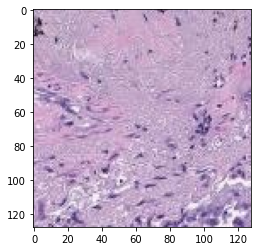

In [ ]:
plt.imshow(x_train_acinar[2000])

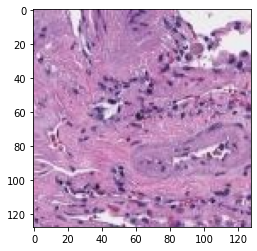

In [ ]:
plt.imshow(x_train_lepidic[2000])

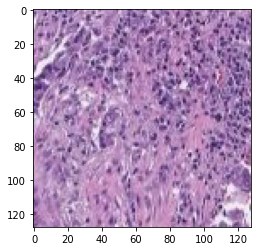

In [ ]:
plt.imshow(x_train_micropapillary[2000])

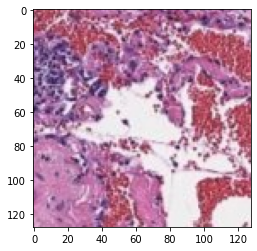

In [ ]:
plt.imshow(x_train_papillary[2000])

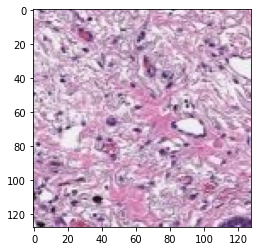

In [ ]:
plt.imshow(x_train_solid[2000])

In [ ]:
Final_Dataset = np.vstack((x_train_acinar, x_train_lepidic,x_train_micropapillary,x_train_papillary,x_train_solid))

In [ ]:
Final_Dataset.shape

(13165, 128, 128, 3)

In [ ]:
Final_Label = y_train_acinar + y_train_lepidic + y_train_micropapillary + y_train_papillary + y_train_solid

In [ ]:
len(Final_Label)

13165

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    Final_Dataset, Final_Label, 
    test_size=0.40, 
    random_state=2020
)

In [ ]:
x_train.shape

(7899, 128, 128, 3)

In [ ]:
x_val.shape

(5266, 128, 128, 3)

In [ ]:
y_train=np.array(y_train)
y_val=np.array(y_val)

In [ ]:
import pathlib
import random

def gen_image_paths_train(num_level=2):
    all_images_image_paths = []
    all_images_image_labels = []

    for i in range(1):

        slide_path = i

        #img_num = slide_path.split('_')[1].strip(".tiff")

        data_root_acinar = pathlib.Path('./Dataset/train_filter/level_' + str(num_level) + '/acinar')
        all_image_paths_acinar = list(data_root_acinar.glob('*'))
        num_acinar_images = len(all_image_paths_acinar)
        print("\nTotal number of acinar histological pattern images",num_acinar_images)
        

        data_root_lepidic = pathlib.Path('./Dataset/train_filter/level_' + str(num_level) + '/lepidic')
        all_image_paths_lepidic = list(data_root_lepidic.glob('*'))
        num_lepidic_images = len(all_image_paths_lepidic)
        print("\nTotal number of lepidic histological pattern images",num_lepidic_images)
      

        data_root_micropapillary = pathlib.Path('./Dataset/train_filter/level_' + str(num_level) + '/micropapillary')
        all_image_paths_micropapillary = list(data_root_micropapillary.glob('*'))
        num_micropapillary_images = len(all_image_paths_micropapillary)
        print("\nTotal number of micropapillary histological pattern images",num_micropapillary_images)
       

        data_root_papillary = pathlib.Path('./Dataset/train_filter/level_' + str(num_level) + '/papillary')
        all_image_paths_papillary = list(data_root_papillary.glob('*'))
        num_papillary_images = len(all_image_paths_papillary)
        print("\nTotal number of papillary histological pattern images",num_papillary_images)
      

        data_root_solid = pathlib.Path('./Dataset/train_filter/level_' + str(num_level) + '/solid')
        all_image_paths_solid = list(data_root_solid.glob('*'))
        print("\nTotal number of solid histological pattern images",len(all_image_paths_solid))
        

    
        all_image_paths = [str(path) for path in all_image_paths_acinar + all_image_paths_lepidic + all_image_paths_micropapillary + all_image_paths_papillary + all_image_paths_solid]
        random.shuffle(all_image_paths)

        data_root = pathlib.Path('./Dataset/train_filter/level_' + str(num_level))

        label_names = sorted(item.name for item in data_root.glob('*') if item.is_dir())

        label_to_index = dict((name, index) for index, name in enumerate(label_names))

        all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                            for path in all_image_paths]

        #update all image path lists
        all_images_image_paths = all_images_image_paths + all_image_paths
        all_images_image_labels = all_images_image_labels + all_image_labels

    return all_images_image_paths, all_images_image_labels

# Load and preprocess image.
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

#Preprocess image
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 128])
    image /= 255.0  # normalize to [0,1] range

    return image    

def create_tf_dataset_train(all_image_paths_1, all_image_paths_2, all_image_paths_3, all_image_labels):

    path_ds_1 = tf.data.Dataset.from_tensor_slices(all_image_paths_1)
    image_ds_1 = path_ds_1.map(load_and_preprocess_image, num_parallel_calls=8)

    #path_ds_2 = tf.data.Dataset.from_tensor_slices(all_image_paths_2)
    #image_ds_2 = path_ds_2.map(load_and_preprocess_image, num_parallel_calls=8)

    #path_ds_3 = tf.data.Dataset.from_tensor_slices(all_image_paths_3)
    #image_ds3_3 = path_ds_3.map(load_and_preprocess_image, num_parallel_calls=8)

    label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))

    image_label_ds = tf.data.Dataset.zip((image_ds_1, label_ds))

    BATCH_SIZE = 4

    steps_per_epoch = int(np.ceil(len(all_image_paths_1)/BATCH_SIZE))

    # Setting a shuffle buffer size larger than the dataset ensures that the data is completely shuffled.
    ds = image_label_ds.repeat()
    ds = ds.shuffle(buffer_size=4000)
    ds = ds.batch(BATCH_SIZE)
    # `prefetch` lets the dataset fetches batches, asynchronously while the model is training.
    ds = ds.prefetch(1)


    return ds, steps_per_epoch


def train_part(num_level_1=2, num_level_2=2, num_level_3=2):

    # change input here from a specific image to an image path
    all_image_paths_1, all_image_labels_1 = gen_image_paths_train(num_level_1)


    ## Create tf.Dataset for training
    ds, steps_per_epoch = create_tf_dataset_train(all_image_paths_1, all_image_paths_1, all_image_paths_1,all_image_labels_1)

    return ds, steps_per_epoch            

In [ ]:
ds_train, steps_per_epoch_train = train_part()


Total number of acinar histological pattern images 3110

Total number of lepidic histological pattern images 2539

Total number of micropapillary histological pattern images 2516

Total number of papillary histological pattern images 2494

Total number of solid histological pattern images 2506


In [ ]:
ds_train

<PrefetchDataset shapes: ((None, 128, 128, 3), (None,)), types: (tf.float32, tf.int64)>

In [ ]:
steps_per_epoch_train

3292

In [ ]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers

import os
import numpy as np

from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, GlobalAveragePooling2D, GlobalMaxPooling2D, Flatten, Concatenate, Conv2D, Input, Flatten, MaxPooling2D, UpSampling2D, concatenate, Cropping2D, Reshape, BatchNormalization

from tensorflow.keras.applications.nasnet import NASNetLarge
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.layers import Dense, concatenate
from tensorflow.keras.models import Model, load_model
%matplotlib inline


import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers
import pandas as pd

In [ ]:
def Dense_Net_121():
    
    inputs = Input((128, 128, 3))
    densenet121 = tf.keras.applications.DenseNet121(input_tensor=inputs, weights='imagenet', include_top=False)
    x = densenet121.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(16, activation='relu')(x)
    y = Dense(5, activation='softmax')(x)
    
    for layer in densenet121.layers:
        layer.trainable = False

    model = Model(inputs=inputs, outputs=y)

    return model

In [ ]:
dense= Dense_Net_121()

29089792/29084464 [==============================] - 0s 0us/step


In [ ]:
with tf.device('/GPU:0'):
    print("TRUE")
    dense.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.sparse_categorical_crossentropy, 
              metrics = ['acc'])

    history_dense_121 =dense.fit(ds_train, epochs=100, steps_per_epoch=steps_per_epoch_train, verbose=1)

TRUE
Epoch 1/100
3292/3292 [==============================] - 94s 29ms/step - loss: 0.6776 - acc: 0.7159
Epoch 2/100
3292/3292 [==============================] - 95s 29ms/step - loss: 0.6819 - acc: 0.7089
Epoch 3/100
3292/3292 [==============================] - 93s 28ms/step - loss: 0.6752 - acc: 0.7135
Epoch 4/100
3292/3292 [==============================] - 94s 29ms/step - loss: 0.6743 - acc: 0.7212
Epoch 5/100
3292/3292 [==============================] - 93s 28ms/step - loss: 0.6749 - acc: 0.7204
Epoch 6/100
3292/3292 [==============================] - 93s 28ms/step - loss: 0.6708 - acc: 0.7187
Epoch 7/100
3292/3292 [==============================] - 93s 28ms/step - loss: 0.6636 - acc: 0.7217
Epoch 8/100
3292/3292 [==============================] - 92s 28ms/step - loss: 0.6696 - acc: 0.7191
Epoch 9/100
3292/3292 [==============================] - 93s 28ms/step - loss: 0.6786 - acc: 0.7159
Epoch 10/100
3292/3292 [==============================] - 93s 28ms/step - loss: 0.6658 - acc: 0

In [ ]:
dense.load_weights("/content/drive/MyDrive/model.h5")

In [ ]:
#testing purpose below script

In [ ]:
import tensorflow as tf


import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
from skimage.color import rgb2gray
import cv2
import os
import random
import pathlib
import openslide
import PIL
from PIL import Image
from openslide.lowlevel import *
from openslide.lowlevel import _convert


def test_part_1(testing_image_path, num_pixels=64, num_level=2):

    slide_path_test = testing_image_path
    tumor_mask_path_test = '../input/prostate-cancer-grade-assessment/train_label_masks/'+slide_path_test[-37:-5]+'_mask.tiff'
    print(slide_path_test, tumor_mask_path_test)

    # Retrieve slide parameters before overwriting
    slide, tumor_mask = load_image(slide_path_test, tumor_mask_path_test)
    width, height = slide.level_dimensions[num_level][0], slide.level_dimensions[num_level][1]

    # Read training image at slide level 3
    slide = read_slide(slide,
                       x=0,
                       y=0,
                       level=num_level,
                       width=width,
                       height=height)

    tumor_mask = read_slide(tumor_mask,
                            x=0,
                            y=0,
                            level=num_level,
                            width=width,
                            height=height)

    # Retrieve new array dimensions
    image_depth, image_width = int(np.ceil(slide.shape[0] / num_pixels)), int(np.ceil(slide.shape[1] / num_pixels))

    # Convert the mask from RGB to a black/white binary
    tumor_mask = tumor_mask[:, :, 0]

    # Determine the portions of the image that are tissue
    tissue_pixels = list(find_tissue_pixels(slide))

    # Turn the tissue pixels into a mask
    tissue_regions = apply_mask(slide, tissue_pixels)

    split_image_test(slide, tissue_regions, num_pixels, num_level, slide_path_test)
    return image_depth, image_width, tumor_mask, tissue_regions, slide

def load_image(slide_path, tumor_mask_path):

    # Loading the slide image and the tumor mask image
    slide = open_slide(slide_path)
   
    tumor_mask = open_slide('../input/prostate-cancer-grade-assessment/train_label_masks/'+tumor_mask_path[-42:-10]+'_mask.tiff')
    
    # Checking if the dimensions of the mask image and the slide image match or not
    for i in range(len(slide.level_dimensions)-1):
        assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
        assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]
    print(slide.level_dimensions)
    print("---",slide.level_downsamples[2],slide.level_dimensions[2][0])
    # Verify downsampling works as expected
    width, height = slide.level_dimensions[2]
    print(width,height)
    #assert width * slide.level_downsamples[2] == slide.level_dimensions[2][0]
    #assert height * slide.level_downsamples[2] == slide.level_dimensions[0][1]

    return slide, tumor_mask    


def read_slide(slide, x, y, level, width, height, as_float=False):

    # Reading the slides and converting them into a RGB numpy array
    openslide.lowlevel._load_image = _load_image_morethan_2_29
    im = slide.read_region((x, y), level, (width, height))
    im = im.convert('RGB')  # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im  

def _load_image_lessthan_2_29(buf, size):
    '''buf must be a mutable buffer.'''
    _convert.argb2rgba(buf)
    return PIL.Image.frombuffer('RGBA', size, buf, 'raw', 'RGBA', 0, 1)


def _load_image_morethan_2_29(buf, size):
    '''buf must be a buffer.'''

    # Load entire buffer at once if possible
    MAX_PIXELS_PER_LOAD = (1 << 29) - 1
    # Otherwise, use chunks smaller than the maximum to reduce memory
    # requirements
    PIXELS_PER_LOAD = 1 << 26

    def do_load(buf, size):
        '''buf can be a string, but should be a ctypes buffer to avoid an
        extra copy in the caller.'''
        # First reorder the bytes in a pixel from native-endian aRGB to
        # big-endian RGBa to work around limitations in RGBa loader
        rawmode = (sys.byteorder == 'little') and 'BGRA' or 'ARGB'
        buf = PIL.Image.frombuffer('RGBA', size, buf, 'raw', rawmode, 0, 1)
        # Image.tobytes() is named tostring() in Pillow 1.x and PIL
        buf = (getattr(buf, 'tobytes', None) or buf.tostring)()
        # Now load the image as RGBA, undoing premultiplication
        return PIL.Image.frombuffer('RGBA', size, buf, 'raw', 'RGBa', 0, 1)

    # Fast path for small buffers
    w, h = size
    if w * h <= MAX_PIXELS_PER_LOAD:
        return do_load(buf, size)

    # Load in chunks to avoid OverflowError in PIL.Image.frombuffer()
    # https://github.com/python-pillow/Pillow/issues/1475
    if w > PIXELS_PER_LOAD:
        # We could support this, but it seems like overkill
        raise ValueError('Width %d is too large (maximum %d)' %
                         (w, PIXELS_PER_LOAD))
    rows_per_load = PIXELS_PER_LOAD // w
    img = PIL.Image.new('RGBA', (w, h))
    for y in range(0, h, rows_per_load):
        rows = min(h - y, rows_per_load)
        if sys.version[0] == '2':
            chunk = buffer(buf, 4 * y * w, 4 * rows * w)
        else:
            # PIL.Image.frombuffer() won't take a memoryview or
            # bytearray, so we can't avoid copying
            chunk = memoryview(buf)[y * w:(y + rows) * w].tobytes()
        img.paste(do_load(chunk, (w, rows)), (0, y))
    return img      


def find_tissue_pixels(image, intensity=0.8):

    # Finding the pixels having value less than or equal to the intensity value
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])


def apply_mask(im, mask, color=1):

    # Applies the mask to the slides image
    masked = np.zeros((im.shape[0], im.shape[1]))
    for x, y in mask:
        masked[x][y] = color
    return masked


# Save the image as tissue or not
def split_image_test(im, tissue_mask, num_pixels, level_num, slide_path):
    x, y = im.shape[0], im.shape[1]
    x_count, y_count = int(np.ceil(x / num_pixels)), int(np.ceil(y / num_pixels))

    tissue_folder, all_folder = initialize_directories_test(slide_path, level_num)

    try:
        for i in range(x_count):
            for j in range(y_count):
                im_slice = np.zeros((num_pixels, num_pixels, 3))
                im_tissue_slice = np.zeros((num_pixels, num_pixels, 3))
                tissue_mask_slice = np.zeros((num_pixels, num_pixels))

                string_name = 'img_' + str(i * y_count + j)

                # Logic to handle the edges of the images
                if i == x_count - 1:
                    ub_x = x
                    assign_x = x - (x_count - 1) * num_pixels
                else:
                    ub_x = (i + 1) * num_pixels
                    assign_x = num_pixels

                if j == y_count - 1:
                    ub_y = y
                    assign_y = y - (y_count - 1) * num_pixels
                else:
                    ub_y = (j + 1) * num_pixels
                    assign_y = num_pixels

                tissue_mask_slice[0:assign_x, 0:assign_y] = tissue_mask[(i * num_pixels):ub_x, (j * num_pixels):ub_y]

                try:
                    if np.mean(tissue_mask_slice) > 0.7:
                        im_tissue_slice[0:assign_x, 0:assign_y, :] = im[(i * num_pixels):ub_x, (j * num_pixels):ub_y, :]
                        im_file_name_tissue = tissue_folder + string_name + ".jpg"
                        cv2.imwrite(im_file_name_tissue, im_tissue_slice)

                    im_slice[0:assign_x, 0:assign_y, :] = im[(i * num_pixels):ub_x, (j * num_pixels):ub_y, :]
                    im_file_name_all = all_folder + string_name + ".jpg"
                    cv2.imwrite(im_file_name_all, im_slice)

                except Exception as oerr:
                    print('Error with saving:', oerr)

    except Exception as oerr:
        print('Error with slicing:', oerr)


# The function where the images are stored into tumor or no tumor folders
def split_image_and_mask(im, tumor_mask, tissue_mask,  num_pixels, level, slide_path):

    x, y = im.shape[0], im.shape[1]

    # Find the number of image slices that the original image will split into
    x_count, y_count = int(np.ceil(x / num_pixels)), int(np.ceil(y/num_pixels))

    tumor_folder, no_tumor_folder = initialize_directories(slide_path, level)

    try:
        for i in range(x_count):
            for j in range(y_count):
                im_slice = np.zeros((num_pixels, num_pixels, 3))
                tissue_mask_slice = np.zeros((num_pixels, num_pixels))
                tumor_mask_slice = np.zeros((num_pixels, num_pixels))

                string_name = 'img_' + str(i * y_count + j)

                # Logic to handle end conditions
                if i == x_count-1:
                    ub_x = x
                    assign_x = x - (x_count-1)*num_pixels
                else:
                    ub_x = (i+1) * num_pixels
                    assign_x = num_pixels

                if j == y_count-1:
                    ub_y = y
                    assign_y = y - (y_count-1)*num_pixels
                else:
                    ub_y = (j+1) * num_pixels
                    assign_y = num_pixels

                # Assign the pixels to the slice of the tissue mas
                tissue_mask_slice[0:assign_x, 0:assign_y] = tissue_mask[(i*num_pixels) :ub_x, (j * num_pixels) :ub_y]

                try:
                    if np.mean(tissue_mask_slice) > 0.7:
                        im_slice[0:assign_x, 0:assign_y, :] = im[(i*num_pixels) :ub_x, (j * num_pixels) :ub_y, :]
                        tumor_mask_slice[0:assign_x, 0:assign_y] = tumor_mask[(i*num_pixels) :ub_x, (j * num_pixels) :ub_y]

                        if np.max(tumor_mask_slice) > 0:
                            im_file_name = tumor_folder + string_name + ".jpg"
                        else:
                            im_file_name = no_tumor_folder + string_name + ".jpg"

                        cv2.imwrite(im_file_name, im_slice)

                except Exception as oerr:
                    print('Error with saving:', oerr)

    except Exception as oerr:
        print('Error with slicing:', oerr)



# This function makes the directories required during testing
def initialize_directories_test(slide_path, level):

    BASE_DIR = os.getcwd()

    img_num = slide_path.split('_')[1].strip(".tiff")

    DATA = 'data/'
    IMG_NUM_FOLDER = img_num + '/'
    LEVEL_FOLDER = 'level_'+str(level)+'/'
    TISSUE_FOLDER = 'tissue_only/'
    ALL_FOLDER = 'all/'

    DATA_DIR = os.path.join(BASE_DIR, DATA)
    IMG_NUM_DIR = os.path.join(BASE_DIR, DATA, IMG_NUM_FOLDER)
    LEVEL_NUM_DIR = os.path.join(BASE_DIR, DATA, IMG_NUM_FOLDER, LEVEL_FOLDER)
    TISSUE_DIR = os.path.join(BASE_DIR, DATA, IMG_NUM_FOLDER, LEVEL_FOLDER, TISSUE_FOLDER)
    ALL_DIR = os.path.join(BASE_DIR, DATA, IMG_NUM_FOLDER, LEVEL_FOLDER, ALL_FOLDER)

    if not os.path.exists(DATA_DIR):
        os.mkdir(DATA_DIR)
    if not os.path.exists(IMG_NUM_DIR):
        os.mkdir(IMG_NUM_DIR)
    if not os.path.exists(LEVEL_NUM_DIR):
        os.mkdir(LEVEL_NUM_DIR)
    if not os.path.exists(TISSUE_DIR):
        os.mkdir(TISSUE_DIR)
    if not os.path.exists(ALL_DIR):
        os.mkdir(ALL_DIR)

    return DATA + IMG_NUM_FOLDER + LEVEL_FOLDER + TISSUE_FOLDER, DATA + IMG_NUM_FOLDER + LEVEL_FOLDER + ALL_FOLDER

def gen_image_paths(slide_path, level_num=2):
    img_num = slide_path[-37:-5]
    img_test_folder = 'tissue_only'

    data_root = pathlib.Path('data/mages/' + img_num + '/level_' + str(level_num) +'/' + img_test_folder)

    all_image_paths = list(data_root.glob('*'))
    all_image_paths = [str(path) for path in all_image_paths]

    return  all_image_paths   


# Tumor predict mask.
def tumor_predict_mask(test, all_image_paths, depth, width):

    test = test[0:len(all_image_paths), :]
    img_num = np.zeros(len(all_image_paths))
    for i in range(len(all_image_paths)):
        img_num[i] = int(all_image_paths[i].strip('.jpg').split('/')[-1].split('_')[-1])

    # depth, width = int(np.ceil(slide_image.shape[0] / pixel_num)), int(np.ceil(slide_image.shape[1] / pixel_num))

    predictions = np.zeros((depth, width))
    conf_threshold = 0.85

    for i in range(len(test)):
        y = int(img_num[i] // width)
        x = int(np.mod(img_num[i], width))
        predictions[y, x] = int(test[i] > conf_threshold)

    return predictions

In [ ]:
import pathlib
import random

def gen_image_paths_train(training_image_path_list, num_level=2):
    all_images_image_paths = []
    all_images_image_labels = []

    for i in training_image_path_list:

        slide_path = i

        #img_num = slide_path.split('_')[1].strip(".tiff")

        data_root_tumor = pathlib.Path('./Dataset/train_filter/level_' + str(num_level) + '/tumor')
        all_image_paths_tumor = list(data_root_tumor.glob('*'))
        num_tumor_images = len(all_image_paths_tumor)

        data_root_notumor = pathlib.Path('./Dataset/train_filter/level_' + str(num_level) + '/no_tumor')
        all_image_paths_notumor = list(data_root_notumor.glob('*'))
        random.shuffle(all_image_paths_notumor)
        all_image_paths_notumor = all_image_paths_notumor[0:num_tumor_images]

        all_image_paths = [str(path) for path in all_image_paths_tumor + all_image_paths_notumor]
        random.shuffle(all_image_paths)

        data_root = pathlib.Path('./Dataset/train_filter/level_' + str(num_level))
        label_names = sorted(item.name for item in data_root.glob('*') if item.is_dir())
        label_to_index = dict((name, index) for index, name in enumerate(label_names))

        all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                            for path in all_image_paths]

        #update all image path lists
        all_images_image_paths = all_images_image_paths + all_image_paths
        all_images_image_labels = all_images_image_labels + all_image_labels

    return all_images_image_paths, all_images_image_labels

# Load and preprocess image.
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

#Preprocess image
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [64, 64])
    image /= 255.0  # normalize to [0,1] range

    return image    

def create_tf_dataset_train(all_image_paths_1, all_image_paths_2, all_image_paths_3):

    path_ds_1 = tf.data.Dataset.from_tensor_slices(all_image_paths_1)
    image_ds_1 = path_ds_1.map(load_and_preprocess_image, num_parallel_calls=8)

   
   

    image_label_ds = tf.data.Dataset.zip(image_ds_1)

    BATCH_SIZE = 4

    steps_per_epoch = int(np.ceil(len(all_image_paths_1)/BATCH_SIZE))

    # Setting a shuffle buffer size larger than the dataset ensures that the data is completely shuffled.
    ds = image_label_ds.repeat()
    ds = ds.shuffle(buffer_size=4000)
    ds = ds.batch(BATCH_SIZE)
    # `prefetch` lets the dataset fetches batches, asynchronously while the model is training.
    ds = ds.prefetch(1)


    return ds, steps_per_epoch


def train_part(training_image_path_list, num_level_1=2, num_level_2=2, num_level_3=2):

    # change input here from a specific image to an image path
    all_image_paths_1= gen_image_paths(training_image_path_list, 1)
    
    
    #steps_per_epoch = int(np.ceil(len(x_train)/BATCH_SIZE))
    ## Create tf.Dataset for training
    ds, steps_per_epoch = create_tf_dataset_train(all_image_paths_1, all_image_paths_1, all_image_paths_1)
    print(steps_per_epoch)
    

    return ds, steps_per_epoch 

In [ ]:
!mkdir data
!mkdir data/mages
with strategy.scope():
    k=5001
    test_path='../input/prostate-cancer-grade-assessment/train_images/'+valid_image_path_list[k]
    
    image_depth, image_width, tumor_mask, tissue_regions, slide_image_test = test_part_1(test_path ,num_pixels=64,num_level = 1)
    all_image_paths_1= gen_image_paths(valid_image_path_list[k],1)
    
    ds_test, steps_per_epoch_test = train_part(valid_image_path_list[k])
    steps_per_epoch_test=47
    test_predicts = model.predict(valid_dataset)
    predictions = tumor_predict_mask(test_predicts, all_image_paths_1, image_depth, image_width)

    import matplotlib
    cmap1 = matplotlib.colors.ListedColormap(['black', 'darkblue', 'green', 'yellow', 'orange', 'red'])
    cmap = matplotlib.colors.ListedColormap(['black', 'darkblue', 'green', 'yellow', 'orange', 'cyan'])
    plt.figure(figsize=(50,20))
    plt.subplot(1,3,1)
    plt.imshow(slide_image_test)
    plt.imshow(tumor_mask,cmap=cmap1, alpha=0.5)
    plt.grid(False)
    plt.subplot(1,3,2)
    plt.imshow(slide_image_test)
    plt.imshow(predictions, cmap=cmap) 
    plt.grid(False)

!rm -r ./data